# Data Scientist Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

The following notebook shows the implementation of a real-world machine learning application. CharityML is a fictitious charity organization that relies upon donations to support people with an interest in machine learning. To avoid excess mailing and operational costs, CharityML wants to target potential donors based on a predictive system which identifies individuals who meet or exceed a certain income threshold. Starting from census based data from 1994, a demostrative example of ensembling a pipeline going from cleaning and preprocessing data in the right formats, up to choosing and optimizing the best among three candidate models, is detailed in the cells below. 

In accordance to Udacity guidelines, some minor changes were made to the original dataset. The census data originates from
the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income), as presented and published as _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_._(Kohavi and Becker, 1996) and available
[online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf) here.

----
## 1) Data exploration

The label we are trying to predict, that is whether an individual earned $50,000 or above, is part of the last column named `'income'`. All the remaining columns are socio-economic attributes of each individual.

In [2]:
# Import libraries:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Allow warnings just once: for model fitting especially
import warnings

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first 5 records
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


#### Response variable
This project is about supervised learning because a clear outcome is identified, and can be further characterized as a classification problem because we are interested in predicting whether an individual falls within any of two categories: "makes 50k or above" or not. As such, income is presented in the dataset as continuous and must be transformed into categorical. Before doing this, let's first make a brief assessment of people actually belonging to either group.

In [3]:
#Total number of records
n_records = data.shape[0]

#Number of records where individual's income is more than $50,000
above_50 = data['income'] == '>50K'  ##(type boolean, True=1, False=0)
n_greater_50k = above_50.sum()

#Number of records where individual's income is at most $50,000
n_at_most_50k = (n_records - n_greater_50k)  ##by difference

#Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k/n_records)*100, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


#### Predictors
** Exploration of features, attributes, or characteristics listed for each individual in the dataset **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## 2) Data preparation
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. An example of a non-skewed feature (`'hours-per-week'`) is plotted also for reference.

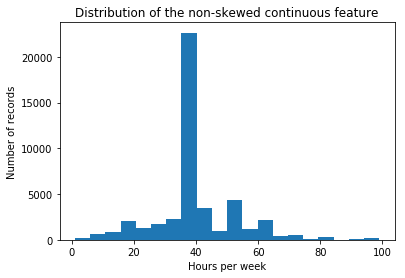

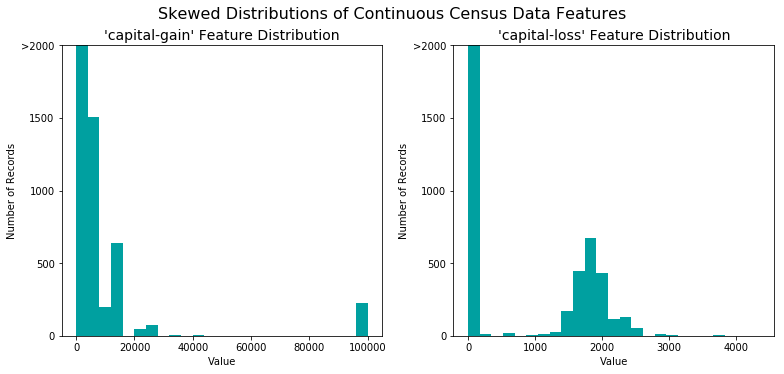

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Extra: How does a non-skewed feature looks like in the dataset(hours-per-week)
import matplotlib.pyplot as plt
data.loc[:,'hours-per-week'].plot(kind='hist', bins=20, range=(1,99))
plt.xlabel('Hours per week')
plt.ylabel('Number of records')
plt.title('Distribution of the non-skewed continuous feature')
plt.show()

# Visualize skewed continuous features of original data
vs.distribution(features_raw)
#vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

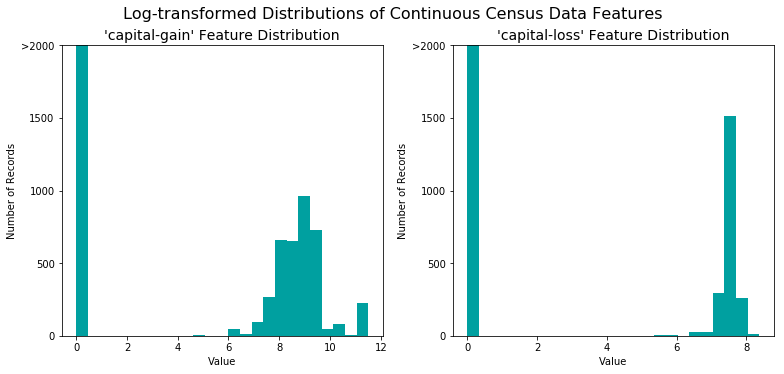

In [5]:
# Log-transform the skewed features
skewed= ['capital-gain', 'capital-loss']
features_Log_transformed= pd.DataFrame(data= features_raw)
features_Log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x+1))

# Visualize the new log distributions
vs.distribution(features_Log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below. The `MinMaxScaler` class included in the `sklearn.preprocessing`sub-module helps to normalize a dataset in a few steps.

Documentation: [`sklearn.preprocessing.MinMaxScaler`](http://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [6]:
#Turn off warnings
warnings.filterwarnings('ignore')

# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features (range between 0,1)
scaler = MinMaxScaler()
numerical= ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_Log_minmax_transform = pd.DataFrame(data = features_Log_transformed)
features_Log_minmax_transform[numerical] = scaler.fit_transform(features_Log_transformed[numerical])

#Show examples of records after scaling
display(features_Log_minmax_transform.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Transforming categorical features

For supervised learning algorithms to work, sklearn expect numeric inputs. Therefore, levels within each categorical feature in the census data need to be brought to mutually exclusive numerical labels. For three levels of certain categorical variable, say `(high, mid, low)` the corresponding input vector for a person in the `high` group should be something like `(1,0,0)` whereas `(0,0,1)` would indicate a person in the low-group . A popular technique called **one-hot encoding** allows for quick _**'dummy-ing'**_, or to automatically create _"dummy"_ variables for each possible category of non-numeric features in the dataset. Here, we use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data. Although `'income'` is to be transformed into a categorical variable with two levels, we avoid using one-hot encoding and simply convert it into a binary variable, i.e. `('if 'income raw'<=50k then 1 else 0')`.

In [7]:
#### EXTRA: Checking number of unique values for each categorical####
data_check= features_Log_minmax_transform
categoricals= [col for col in data_check.columns if type(data_check[col][1]) == str] #which is categorical?

counter=[]
for col in data_check[categoricals].columns:
    uniques= len(data_check[categoricals][col].unique())
    counter.append(uniques)

print(categoricals)
check= sum(counter)+5 # 5 is the number of continuous features
print('\nTotal feature-dummy-levels should be {}'.format(str(check)))

# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()

features_final= pd.get_dummies(data= features_Log_minmax_transform)

# Encode the 'income_raw' data to numerical values
def to_bin(n):
    return 1 if n == '>50K' else 0

raw_values =  np.array([to_bin(value) for value in income_raw.values])
income= pd.Series(raw_values)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
display(features_final.head(n=5))
print("{} total features after one-hot encoding.".format(len(encoded)))
# Uncomment the following line to see the encoded feature names
#print(encoded)

['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Total feature-dummy-levels should be 103


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


103 total features after one-hot encoding.


---
## 2) Modeling

### Shuffle and Split Data
Now that all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized, we can move forward with modeling income of a person as a function of his/her socio-economic conditions. We start with splitting the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [8]:
# Import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluate Model Performance
In this section, we will investigate three different algorithms and determine which is best at modeling the data relative to a baseline *naive predictor*.

### Metrics
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. CharityML must prioritize therefore the model's ability to precisely predict those in or above the 50k threshold rather than **recall** actual individuals under such a denomination in our dataset. The metrics to guide our choice of the best model are **accuracy**, i.e. (correctly predicted 50k earners/total number of predictions), and also the **F-beta score**, tuned to place more emphasis on **precision**. While accuracy accounts for a good prediction regardless of which label we are looking at, precision is more objective and focuses on the number of correctly predicted 50k earners who are actually 50k-individuals identified as such in the dataset. The formula for precision is `[True Positives/(True Positives + False Positives)]`, where a true positive here means an actual 50k earner who was predicted as such by the model. Conversely, a false positive stands for an individual making less than 50k but misclassified otherwise by the model.

Although we don't want to emphasize too much on the math behind performance metrics, a brief look at how a **F-beta score** is computed can be informative.

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

It is worth noting that accuracy, being a rough measure of good predicitve ability by a model, can be highly sensitive to unbalanced data. Actually, less than 25% of individuals in the 1994 census data earned above 50k. With that said, the F-score complement well our performance evaluation, as it weights both precision and recall. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. On the other hand, the recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally baseline models would be either the results of a previous model or could be based on a research paper to test against. When there is no benchmark model set, getting a result better than random choice is a good point to start.

In [9]:
TP = np.sum(income)   #sum of ones of the recoded income attribute when preprocessing (Naive case)
FP = income.count() - TP
TN= 0 # no true-negatives predicted by naive
FN= 0 # no false-negatives predicted by naive

# Calculate accuracy, precision and recall

accuracy = TP / (TP + FP + TN + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using beta = 0.5 to correct for more precision.
beta= 0.5
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))

# Print the results
print('Answer to question one')
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Answer to question one
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Question 2 - Model Application
List three supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

### Answer Question 2: Model Election

I picked Logistic regression, Naive Bayes, and an ensemble method (Random Forests) to predict potential donors based on socio-demographic information. 

- **Logistic regression**:
Logistic regression is **applied** to model relationships where the response is binary in nature. The responses are usually log-transformed and modeled as probabilities connected to a linear combination of the predictors via a sigmoidal function. The marketing research department of a cola-drink company can use logistic regression, **for example**, to predict whether consumers will purchase a new version of its top selling product or not. Among its **strenghts**, it can be easier and faster to implement than other complex algorithms as it is basically an extension of linear regression to model binary election problems. Because of its simplicity, it can be trained quickly and be set as a benchmark against more complex, and perhaps, more accurate algorithms. Among the **weaknessess** of logistic regression, it can be sensitive to attributes that are poorly related to the outcome we want to predict and can lead to overfitting (i.e great performance on training sets yet performing poorly on new test data). Logistic regression **is a good choice here** because predicting potential donors is in terms of classifying between two categories (i.e. income above or below 50k).


- **Naive Bayes (NB)**:
Naive Bayes updates a set of a priori assumptions about the data (i.e. _what is the probability for a combination of explanatory variables that resulted in a particular response label?_) into a new set of beliefs (i.e. _how likely is for an observed class to occur given the occurrence of one or more explanatories?_). Imposing some tricks, such as assuming that each explanatory-label combination is independent from the others, **Naive Bayes can be quickly** implemented for fast classification of events in a dataset. For example, **spam classification** is an application of the Naive Bayes algorithm where long strings of text can be splitted, counted, and organized as explanatories to predict whether an email containing such words would be categorized as spam or not. Yet, even though NB is simple and quick to train, it can **perform weakly** to model classification problems with stronger theoretical backgrounds, such as biophysical or economic phenomena, whose datasets are highly collinear or either contain labels or explanatories recorded as continuous variables. Because it is easy to train and implement, **I picked NB** as a slightly more elegant alternative for model bechmark **for the CharityML problem**, specially against the seemingly more suitable logistic and random forest algorithmns.


- **Random Forest (RF)**:
Random Forests is a great approach that expands the information gains of succesive data splits of a decision-tree by also resampling and averaging among multiple decision trees for a better prediction. **RF can minimize overfitting** issues encountered when fitting a decision tree, especially in highly dimensional datasets, due to the randomness component added by multiple resampling and filtering of the best predictors in the original dataset. While training of a RF can be quick, **RF may become slower** as the algorithm is given new validation datasets and this can require continuous hyperparameter tuning in a machine learning industry setting. I am in the agricultural research sector, and **currently RFs are widely used by ag. companies** as their baseline model, for example, to value land-prices as a function of historical agronomic, social, and economic data (e.g. crop rating indexes, soil properties, land-ownership, interest rates. etc). **I chose RF** as my third model here to check if the prediction ability of logistic regression can be outperformed by a relatively more complex classifier.

Three consulted references and pretty cool blogs to check out: 
* _logistic regression:_ (https://machinelearning-blog.com/2018/04/23/logistic-regression-101/)
* _Naive Bayes:_ (https://towardsdatascience.com/introduction-to-naive-bayes-classification-4cffabb1ae54)
* _For Random Forests: a great and classic reference text: An introduction to statistical learning (James, Witten, Hastie, and Tibshirani, 2017)_ (http://www-bcf.usc.edu/~gareth/ISL/)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model, it's important to create a pipeline that allows for quick and effective model training using various sizes of training data as well as model prediction on the testing data. The plan includes:

- Import metric scores: `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
- Fit the learner to the sampled training data and record the training time.
- Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
  - Record the total prediction time.
- Calculate the accuracy score for both the training subset and testing set.
- Calculate the F-score for both the training subset and testing set at the right beta parameter.

In [1]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    #Fit the learner to the training data using slicing with 'sample_size' 
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end - start
        
    #Get the predictions on the test set(X_test),
    #then get predictions on the first 300 training samples(X_train) using .predict()
    
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta= 0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta= 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

Now we import, initialize and train the models at different sample sizes. At this point, we train the models at the default hyperparameters within each model class. Model tuning and optimization comes later.
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
MultinomialNB trained on 361 samples.
MultinomialNB trained on 3617 samples.
MultinomialNB trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


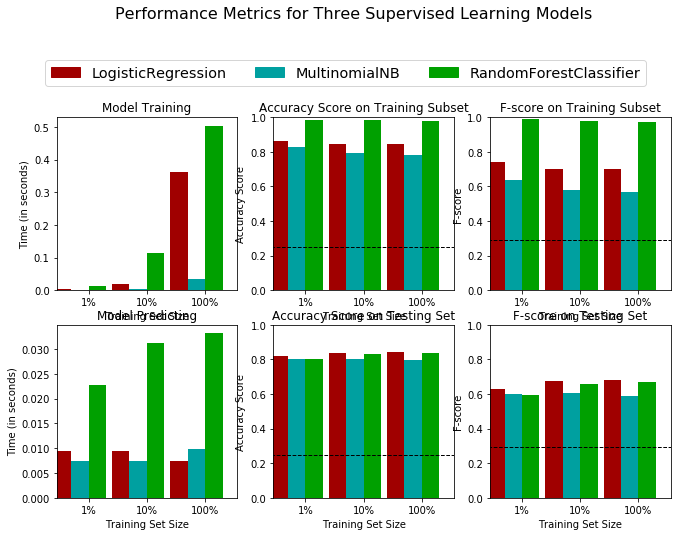

In [13]:
#Set wranings at minimum: new versions may set default parameters at different levels
warnings.filterwarnings(action='ignore')
#Import the four supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#Initialize the three models
clf_A = LogisticRegression()
clf_B = MultinomialNB()
clf_C = RandomForestClassifier()


#Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.10 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [15]:
### Model performance with 100% of the testing data:
print('F-test, 100% training data')
for key,values in results.items():
    print(key, ':', round(values[2]['f_test'], 3))

print(20*'---')

print('Accuracy, 100% training data')
for key,values in results.items():
    print(key, ':', round(values[2]['acc_test'], 3))

F-test, 100% training data
LogisticRegression : 0.683
MultinomialNB : 0.591
RandomForestClassifier : 0.669
------------------------------------------------------------
Accuracy, 100% training data
LogisticRegression : 0.842
MultinomialNB : 0.796
RandomForestClassifier : 0.836



----
## Improving Results

### Question 3 - Choosing the Best Model

* Based on the evaluation performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

### Answer to question 3:
The algorithm that better predict potential donors using our demographic dataset was the logistic regression. The logistic regression F-score was 0.68 when testing it against 100% of the training data. It compared relatively higher than the ensemble (Random Forests, F=0.66), and consistently outperformed the other "benchmark" I chose for this problem: naive bayes classifier. Computation time for the three methods increased with sample size as expected, but logistic regression took consistently less time to train and test compared to random forests. Roughly, testing the model with the full dataset took 3.5 times less with the logistic than the random forest classifier. Finally, besides performance and time savings, the logistic regression proved to be a great choice given the binary nature of the response we are trying to predict, which is classifying between individuals who make above or below 50k annually.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

### ***Answer to question 4

Based on a suite of socio-economic conditions, logistic regression allows us to predict whether a person belongs to one of two categores, that is, whether he or she would earn 50k dollars per year or not. Simply put, logistic regression implements a few mathematical tricks by which our predictions take on a probability between 0 and 1. Thus, every time a new observation (i.e. a a person) is considered, the algorithm picks its corresponding socio-economic attributes, feed them into an equation, predicts its outome, and applies a decision-rule. If this person-predicted response is 0.5 or above, then the algorithm will label him/her as someone who makes 50k a year and is more likely to donate. Conversely, if the predicted outcome for an individual is below 0.5, then he or she would make less than 50k and is less likely to contribute.

### Implementation: Model Tuning

Here we tune the chosen model. Using grid search (`GridSearchCV`), we target at least one important parameter tuned at different values. You The grid searching procedure should use the entire training set. The plan for parameter optimization is:

- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier chosen before and store it in `clf`.
- Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters to tune for the chosen model. (_`parameters = {'parameter' : [list of values]}`._)
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [16]:
# Shut warnings off:
warnings.filterwarnings(action='ignore')

#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression()

#Create the parameters list you wish to tune, using a dictionary if needed.
#parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
# Choose tune in to regularize  given the large dimensionality (dummys)
parameters = {"C":[0.0001, 0.001, 0.01, 0.1, 0.5, 0.99, 1],
              "penalty":['l1','l2'],
              "class_weight":[None, 'balanced']}

#Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta= 0.5)

#Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, 
                        param_grid= parameters,
                        scoring= scorer)

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

#Get the estimator
best_clf = grid_fit.best_estimator_

#Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

#Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8420
Final F-score on the testing data: 0.6842


### Question 5 - Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.8419      |      0.8420     |
| F-score        |       0.6832      |      0.6842     |


#### Answer to question 5:
Both accuracy and the combined F-score remained unchanged for the logistic regression after optimization. I had though that given the high dimensionality we enforced with the one-hot dummy encoding of our data, we could reduce the likelihood of overfitting by 1) regularizing the model, and 2) adjusting weights proportionally to the inputs, much like in a weighted regression. It turns out, model performance remained the same yet it was shown to be much better relative to the naive benchmark suggested (i.e. 25% accurate donor identification by pure chance), and the more elegant naive approach I proposed (Naive bayes: 79%).

Relative to the zero improvement of my regularized logistic regression, Sebastian Raschka (a great data scientist I admire), has pointed out in a KD nuggets post, that regularizing a logistic model penalizes complexity and helps improving generalization of its performance only when testing it against new data. He implies that regularization should not "improve" performance on the training dataset, which I did.

***source: https://www.kdnuggets.com/2016/06/regularization-logistic-regression.html

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We perform feature importance selection using the `feature_importance_` attribute embedded in the Ranfom forest class. The goal is identifying the 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

In [17]:
features_intuition= ['occupation','education','capital-gain','sex','hours-per-week']
print(features_intuition)

['occupation', 'education', 'capital-gain', 'sex', 'hours-per-week']


#### Answer to question 6:

Socio-economic information can be misleading when trying to relate it with an outcome. All else equal however, the more educated and hard-working a person is, the greater the chance would be for him or her to make more money. I believe that the following attributes would better explain a-priori the chances for making 50k or more per year:
_**Education > Occupation > Capital-gain > hours-per-week > sex**_. I am interested in checking if 'sex' would influence our predictions given the alleged gap that exist between men and women's salaries.

### Implementation - Extracting Feature Importance

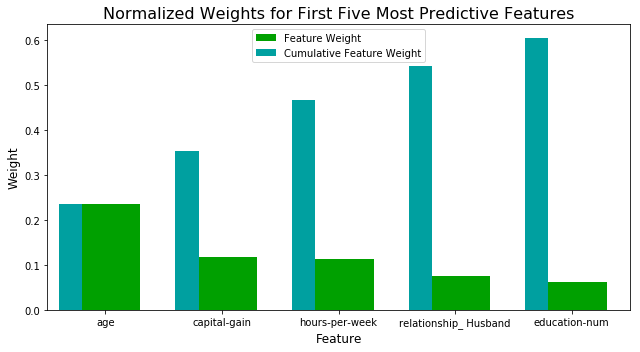

In [18]:
#Shut warnings off:
warnings.filterwarnings(action='ignore')
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier
clf_rf= RandomForestClassifier()

#Train the supervised model on the training set using .fit(X_train, y_train)
model = clf_rf.fit(X_train,y_train)

#Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

#### Answer to question 7:

The ranking for important features with the random forest classifier agreed pretty much with my intuition. **Education, capital gains, and hours-per-week** were important, but contrary to what I had expected, sex and occupation were found not influential in predicting potential donors for Chariry ML. Surprisingly, age and household role were shown to be hihgly influential to predict potential donors to the charity. Out of the effects I overlooked, possibly household-role as a husband may be capturing some of the gender gap effects I mentioned initially while age may be an indicative of seniority, and arguably could be related to higher salaries and higher likelihoods to become a donor. 

### Feature Selection
With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [19]:
# shut warnings off:
warnings.filterwarnings('ignore')
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space

X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier

clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions

reduced_predictions= clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8420
F-score on testing data: 0.6842

Final Model trained on reduced data
------
Accuracy on testing data: 0.8235
F-score on testing data: 0.6420


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

#### Answer to question 8:
The Performance of the logistic regression did not improve with the reduced model. Both the F-score and accuracy scores after reducing the dataset remained unchanged, at 0.6 and 0.8 respectively. For this dataset, computation time was not particularly concerning, but if this model were set to production, reducing feature space would probably bring time savings. Also, we identified attributes of importance with an ensemble method, yet I wonder that maybe another approach suited for variable selection in linear models could be implemented for this logistic regression, such as recursive variable selection.